# Machine Learning - Route Optimization example

###### Links: [Starbucks dataset (Kaggle)](https://www.kaggle.com/starbucks/store-locations)  |  [Article (TowardsDataScience)]()

### 0 - Setup

###### Import pckgs

In [63]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0

## for plotting
import matplotlib.pyplot as plt  #3.3.2
import folium  #0.14.0
from folium import plugins

## for simple routing
import osmnx as ox  #1.2.2
import networkx as nx  #3.0

## for advanced routing 
from ortools.constraint_solver import pywrapcp  #9.6
from ortools.constraint_solver import routing_enums_pb2

###### Import data

In [72]:
city = "Hong Kong"

dtf = pd.read_csv('data_stores.csv')
dtf = dtf[dtf["City"]==city][["City","Street Address","Latitude","Longitude"]].reset_index(drop=True)
dtf = dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("tot:", len(dtf))
dtf.head(3)

tot: 104


,id,City,Street Address,y,x
0,0,Hong Kong,"Shop No.101, 1st Floor, Liberte Place, 8, 33 L...",22.33,114.15
1,1,Hong Kong,"Shop B, Ground Floor, 50 Connaught Central, Ce...",22.29,114.16
2,2,Hong Kong,"Office Lobby, G/F Exchange Square, Central",22.28,114.16


In [85]:
# Pinpoint your location
i = 0
dtf["base"] = dtf["id"].apply(lambda x: 1 if x==i else 0)
start = dtf[dtf["base"]==1][["y","x"]].values[0]

print("start =", start)
dtf.head(3)

start = [ 22.33 114.15]


,id,City,Street Address,y,x,base
0,0,Hong Kong,"Shop No.101, 1st Floor, Liberte Place, 8, 33 L...",22.33,114.15,1
1,1,Hong Kong,"Shop B, Ground Floor, 50 Connaught Central, Ce...",22.29,114.16,0
2,2,Hong Kong,"Office Lobby, G/F Exchange Square, Central",22.28,114.16,0


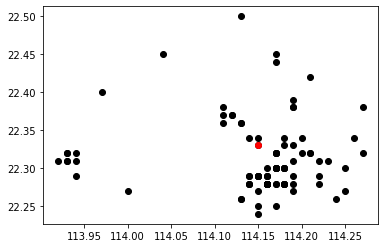

In [92]:
plt.scatter(y=dtf["y"], x=dtf["x"], color="black")
plt.scatter(y=start[0], x=start[1], color="red")
plt.show()

In [93]:
'''
Creates a map with folium.
:parameter
    :param dtf: pandas
    :param (y,x): str - columns with (latitude, longitude)
    :param starting_point: list - (latitude, longitude)
    :param tiles: str - "cartodbpositron", "OpenStreetMap", "Stamen Terrain", "Stamen Toner"
    :param popup: str - column with text to popup if clicked, if None there is no popup
    :param size: str - column with size variable, if None takes size=5
    :param color: str - column with color variable, if None takes default color
    :param lst_colors: list - list with multiple colors to use if color column is not None, if not given it generates randomly
    :param marker: str - column with marker variable, takes up to 7 unique values
:return
    map object to display
'''
def plot_map(dtf, y, x, start, zoom=12, tiles="cartodbpositron", popup=None, size=None, color=None, legend=False, lst_colors=None, marker=None):
    data = dtf.copy()

    ## create columns for plotting
    if color is not None:
        lst_elements = sorted(list(dtf[color].unique()))
        lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))] if lst_colors is None else lst_colors
        data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

    if size is not None:
        scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
        data["size"] = scaler.fit_transform(data[size].values.reshape(-1,1)).reshape(-1)

    ## map
    map_ = folium.Map(location=start, tiles=tiles, zoom_start=zoom)

    if (size is not None) and (color is None): 
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=row["size"]).add_to(map_), axis=1)
    elif (size is None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=5).add_to(map_), axis=1)
    elif (size is not None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=row["size"]).add_to(map_), axis=1)
    else:
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=5).add_to(map_), axis=1)
    
    ## tiles
    layers = ["cartodbpositron", "openstreetmap", "Stamen Terrain", 
              "Stamen Water Color", "Stamen Toner", "cartodbdark_matter"]
    for tile in layers:
        folium.TileLayer(tile).add_to(map_)
    folium.LayerControl(position='bottomright').add_to(map_)
    
    ## legend
    if (color is not None) and (legend is True):
        legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
        for i in lst_elements:
            legend_html = legend_html+"""&nbsp;<i class="fa fa-circle fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+""""></i>&nbsp;"""+str(i)+"""<br>"""
        legend_html = legend_html+"""</div>"""
        map_.get_root().html.add_child(folium.Element(legend_html))
    
    ## add marker
    if marker is not None:
        lst_elements = sorted(list(dtf[marker].unique()))
        lst_colors = ["black","red","blue","green","pink","orange","gray"]  #7
        ### too many values, can't mark
        if len(lst_elements) > len(lst_colors):
            raise Exception("marker has uniques > "+str(len(lst_colors)))
        ### binary case (1/0): mark only 1s
        elif len(lst_elements) == 2:
            data[data[marker]==lst_elements[1]].apply(lambda row: folium.Marker(location=[row[y],row[x]], popup=row[marker], draggable=False, 
                                                                                icon=folium.Icon(color=lst_colors[0])).add_to(map_), axis=1) 
        ### normal case: mark all values
        else:
            for i in lst_elements:
                data[data[marker]==i].apply(lambda row: folium.Marker(location=[row[y],row[x]], popup=row[marker], draggable=False, 
                                                                      icon=folium.Icon(color=lst_colors[lst_elements.index(i)])).add_to(map_), axis=1)
    
    ## full screen
    plugins.Fullscreen(position="topright", title="Expand", title_cancel="Exit", force_separate_button=True).add_to(map_)
    return map_

In [99]:
map_ = plot_map(dtf, y="y", x="x", start=start, zoom=11, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black", "red"])
map_

In [100]:
for i in range(len(dtf)):
    points = [start, dtf[["y","x"]].iloc[i].tolist()]
    folium.PolyLine(points, color="red", weight=0.5, opacity=0.5).add_to(map_)
map_

### 1 - Network Graph

###### Create Graph

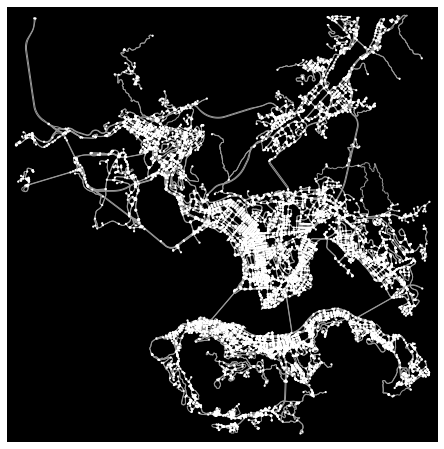

In [168]:
# Create network graph
G = ox.graph_from_point(start, dist=10000, network_type="drive")  #'drive', 'bike', 'walk'
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

fig, ax = ox.plot_graph(G, bgcolor="black", node_size=5, node_color="white", figsize=(16,8))

In [169]:
[i for i in G.nodes()][:10]

[24533064,
 26411640,
 26411641,
 26412251,
 30747332,
 30747334,
 32899260,
 33004487,
 33004488,
 33004530]

In [170]:
# geo-dataframe (nodes)
print("nodes:", len(G.nodes()))
ox.graph_to_gdfs(G, nodes=True, edges=False).reset_index().head(3)

nodes: 9568


,osmid,y,x,street_count,ref,highway,geometry
0,24533064,22.276527,114.173172,3,NaN,NaN,POINT (114.17317 22.27653)
1,26411640,22.250336,114.169964,3,NaN,NaN,POINT (114.16996 22.25034)
2,26411641,22.250545,114.171056,3,NaN,NaN,POINT (114.17106 22.25054)


In [171]:
# geo-dataframe (links)
print("links:", len(G.edges()))
ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index().head(3)

links: 17498


,u,v,key,osmid,oneway,lanes,name,highway,reversed,length,...,geometry,ref,maxspeed,junction,bridge,area,access,tunnel,width,service
0,24533064,1618530627,0,743072632,True,2,莊士敦道 Johnston Road,tertiary,False,38.526,...,"LINESTRING (114.17317 22.27653, 114.17280 22.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24533064,297187423,0,567856161,False,2,莊士敦道 Johnston Road,tertiary,False,30.191,...,"LINESTRING (114.17317 22.27653, 114.17332 22.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26411640,3698862626,0,26560287,True,1,海洋公園道 Ocean Park Road,secondary_link,False,130.623,...,"LINESTRING (114.16996 22.25034, 114.17012 22.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### Shortest Path

In [200]:
end = dtf[dtf["id"]==68][["y","x"]].values[0]
print("from", start, "--> to", end)

from [ 22.33 114.15] --> to [ 22.34 114.15]


In [201]:
# find the nearest node to the start/end location
start_node = ox.distance.nearest_nodes(G, start[1], start[0])
end_node = ox.distance.nearest_nodes(G, end[1], end[0])
print("from", start_node, "--> to", end_node)

from 493883072 --> to 480679404


[493883072, 289293755, 289294146, 289294087, 275816026, 289329905, 1182677821, 1645492788, 1645492916, 1191992694, 5101419365, 332257610, 999331442, 1191992696, 480679312, 999331647, 1641766800, 480679404]


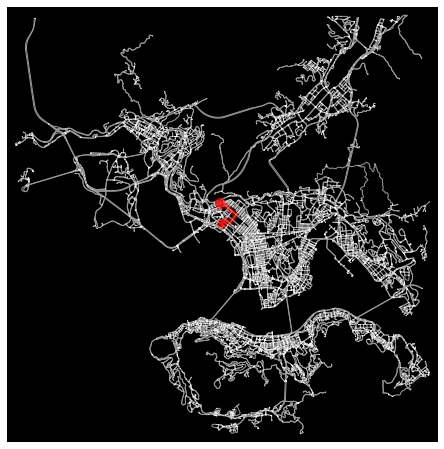

In [202]:
# calculate shortest path
route_lenght = nx.shortest_path(G, source=start_node, target=end_node, method='dijkstra', 
                         weight='lenght')                          
print(route_lenght)

# plot on the graph
fig, ax = ox.plot_graph_route(G, route_lenght, route_color="red", route_linewidth=5, 
                              node_size=1, bgcolor='black', node_color="white", 
                              figsize=(16,8))

[493883072, 289293755, 289294146, 289295423, 289295628, 289295766, 289295767, 289295566, 5101376323, 4844635141, 289295620, 274244744, 1641766635, 1641766639, 1641766654, 999331442, 1191992696, 480679312, 999331647, 1641766800, 480679404]


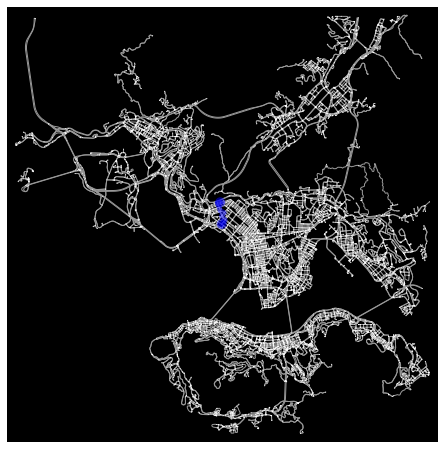

In [203]:
# calculate shortest path
route_time = nx.shortest_path(G, source=start_node, target=end_node, method='dijkstra', 
                             weight='travel_time')                          
print(route_time)

# plot on the graph
fig, ax = ox.plot_graph_route(G, route_time, route_color="blue", route_linewidth=5, 
                              node_size=1, bgcolor='black', node_color="white", 
                              figsize=(16,8))

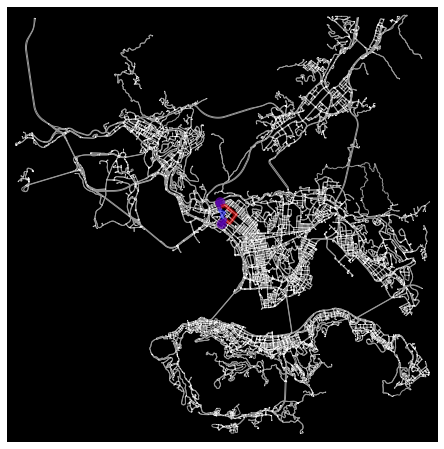

In [204]:
# plot on the graph
fig, ax = ox.plot_graph_routes(G, routes=[route_lenght, route_time], 
                              route_colors=["red","blue"], route_linewidth=5, 
                              node_size=1, bgcolor='black', node_color="white", 
                              figsize=(16,8))

In [205]:
# plot on the map
map_ = plot_map(dtf, y="y", x="x", start=start, zoom=12, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black","red"])

ox.plot_route_folium(G, route=route_lenght, route_map=map_, color="red", weight=1)
ox.plot_route_folium(G, route=route_time, route_map=map_, color="blue", weight=1)
map_

###### Animation

In [52]:
fig = px.scatter_mapbox(df, lon="X_from", lat="Y_from", zoom=13, width=1000, height=800, animation_frame="index",mapbox_style="dark")
fig.data[0].marker = dict(size = 12, color="black")
fig.add_trace(px.scatter_mapbox(start, lon= "X_from", lat="Y_from").data[0])
fig.data[1].marker = dict(size = 15, color="red")
fig.add_trace(px.scatter_mapbox(end, lon= "X_from", lat="Y_from").data[0])
fig.data[2].marker = dict(size = 15, color="green")
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])
fig

NameError: name 'px' is not defined

### 2 - Baseline (Shortest Route)

In [159]:
# Add speed/time
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

hwy_speeds = {'residential': 35, 'secondary': 50, 'tertiary': 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

# calculate two routes by minimizing travel distance vs travel time
orig = list(G)[1]
dest = list(G)[-1]
route1 = nx.shortest_path(G, orig, dest, weight='length')
route2 = nx.shortest_path(G, orig, dest, weight='travel_time')

# compare the two routes
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'travel_time')))
print('Route 1 is', route1_length, 'meters and takes', route1_time, 'seconds.')
print('Route 2 is', route2_length, 'meters and takes', route2_time, 'seconds.')

Route 1 is 10672 meters and takes 615 seconds.
Route 2 is 10672 meters and takes 615 seconds.


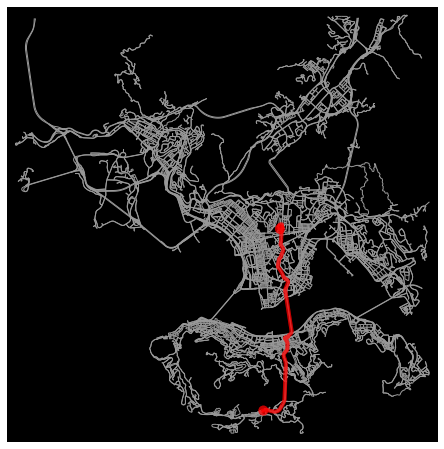

In [162]:
# pick route colors
c1 = 'r' #length
c2 = 'b' #travel_time
rc1 = [c1] * (len(route1) - 1)
rc2 = [c2] * (len(route2) - 1)
rc = rc1 + rc2
nc = [c1, c1, c2, c2]

# plot the routes
fig, ax = ox.plot_graph_routes(G, [route1, route2], route_color=rc, route_linewidth=6,
                               node_size=0, bgcolor='k')

In [163]:
ox.graph_to_gdfs(G, nodes=False)

osmid  oneway lanes   
u           v           key                                         
24533064    1618530627  0                 743072632    True     2  \
            297187423   0                 567856161   False     2   
26411640    3698862626  0                  26560287    True     1   
            26411641    0                  46766846    True     3   
26411641    597665412   0                  86289334    True     4   
...                                             ...     ...   ...   
10864971469 10864971476 0                 950169798    True     1   
10864971471 316731595   0                  28808044    True     1   
            8796274197  0    [950169800, 950169802]    True     1   
10864971476 1636543909  0                 150771607    True     1   
            316731585   0                 723131290    True   NaN   

                                                 name         highway   
u           v           key                                             
24533064    1618530627  0          莊士敦道 Johnston Road        tertiary  \
            297187423   0          莊士敦道 Johnston Road        tertiary   
26411640    3698862626  0       海洋公園道 Ocean Park Road  secondary_link   
            26411641    0    黃竹坑道 Wong Chuk Hang Road           trunk   
26411641    597665412   0    黃竹坑道 Wong Chuk Hang Road           trunk   
...                                               ...             ...   
10864971469 10864971476 0         雅息士道 Essex Crescent    unclassified   
10864971471 316731595   0        金巴倫道 Cumberland Road   tertiary_link   
            8796274197  0         雅息士道 Essex Crescent        tertiary   
10864971476 1636543909  0         雅息士道 Essex Crescent    unclassified   
            316731585   0         雅息士道 Essex Crescent    unclassified   

                            reversed   length  speed_kph  travel_time   
u           v           key                                             
24533064    1618530627  0      False   38.526       60.0          2.3  \
            297187423   0      False   30.191       60.0          1.8   
26411640    3698862626  0      False  130.623       50.0          9.4   
            26411641    0      False  115.025       64.3          6.4   
26411641    597665412   0      False   80.386       64.3          4.5   
...                              ...      ...        ...          ...   
10864971469 10864971476 0      False   70.557       42.7          5.9   
10864971471 316731595   0      False   25.379       50.0          1.8   
            8796274197  0      False   50.270       60.0          3.0   
10864971476 1636543909  0      False   13.212       42.7          1.1   
            316731585   0      False   40.980       42.7          3.5   

                                                                      geometry   
u           v           key                                                      
24533064    1618530627  0    LINESTRING (114.17317 22.27653, 114.17280 22.2...  \
            297187423   0    LINESTRING (114.17317 22.27653, 114.17332 22.2...   
26411640    3698862626  0    LINESTRING (114.16996 22.25034, 114.17012 22.2...   
            26411641    0    LINESTRING (114.16996 22.25034, 114.17011 22.2...   
26411641    597665412   0    LINESTRING (114.17106 22.25054, 114.17123 22.2...   
...                                                                        ...   
10864971469 10864971476 0    LINESTRING (114.17718 22.32887, 114.17724 22.3...   
10864971471 316731595   0    LINESTRING (114.17732 22.33008, 114.17728 22.3...   
            8796274197  0    LINESTRING (114.17732 22.33008, 114.17727 22.3...   
10864971476 1636543909  0    LINESTRING (114.17768 22.32845, 114.17770 22.3...   
            316731585   0    LINESTRING (114.17768 22.32845, 114.17778 22.3...   

                             ref maxspeed  junction bridge area access tunnel   
u           v           key                                                     
24533064    1618530

In [116]:
dtf["node"] = dtf[["y","x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf.head()

,id,City,Street Address,y,x,base,node
0,0,Hong Kong,"Shop No.101, 1st Floor, Liberte Place, 8, 33 L...",22.33,114.15,1,493883072
1,1,Hong Kong,"Shop B, Ground Floor, 50 Connaught Central, Ce...",22.29,114.16,0,4615742665
2,2,Hong Kong,"Office Lobby, G/F Exchange Square, Central",22.28,114.16,0,4361219227
3,3,Hong Kong,"Shop 247, Level 2, Moko 193 Prince Edward Rd W...",22.32,114.17,0,308473193
4,4,Hong Kong,"Shop NO. 106 1/F, East Point City, No. 8, Chun...",22.32,114.27,0,919340746


In [150]:
dic_nodes = {}
for a in dtf["node"].values:
    
    dic = {}
    for b in dtf["node"].tolist():
        if a != b:
            try:
                dic[b] = nx.shortest_path_length(G, a, b)
            except:
                continue
            
    if len(dic) > 0:
        b = min(dic, key=dic.get)
        route = nx.shortest_path(G, source=a, target=b, method='dijkstra')
    
    dic_nodes[a] = (b, route)

In [151]:
dic_nodes

{493883072: (480679404,
  [493883072,
   289293755,
   289294146,
   289294087,
   275816026,
   289329905,
   1182677821,
   1645492788,
   1645492916,
   1191992694,
   5101419365,
   332257610,
   999331442,
   1191992696,
   480679312,
   999331647,
   1641766800,
   480679404]),
 4615742665: (366080838,
  [4615742665,
   274240805,
   274240807,
   274240809,
   2414714348,
   566138430,
   1177098145,
   8532047157,
   653109857,
   1384338208,
   1384338236,
   1384359313,
   281676190,
   2496629828,
   2496629807,
   1013426366,
   5070424649,
   490726643,
   366080838]),
 4361219227: (366080838,
  [4361219227,
   1615603766,
   279077704,
   9189029923,
   279113003,
   245088364,
   984409351,
   984409370,
   288372736,
   984409364,
   165996965,
   366080458,
   2496629828,
   2496629807,
   1013426366,
   5070424649,
   490726643,
   366080838]),
 308473193: (2280300926,
  [308473193,
   308473195,
   992815755,
   992815753,
   2639744193,
   1162875771,
   6843885034,

### 3 - Model (Cheapest Route)

###### Business Parameters

In [153]:
lst_nodes = list(G.nodes())
lst_links = list(G.edges())

In [154]:
n_drivers = 1

# routing manager
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), n_drivers, lst_nodes.index(start_node))

# routing model
model = pywrapcp.RoutingModel(manager)

In [155]:
# Add distance function
def calculate_distance(start_idx, end_idx):
    start_node = lst_nodes[manager.IndexToNode(start_idx)]
    end_node = lst_nodes[manager.IndexToNode(end_idx)]
    distance = nx.shortest_path_length(G, start_node, end_node)
    return distance

transit_cost = model.RegisterTransitCallback(calculate_distance)
model.SetArcCostEvaluatorOfAllVehicles(transit_cost)

In [156]:
# Add distance constraint
name = "Distance"
model.AddDimension(evaluator_index=transit_cost, slack_max=0, capacity=3000, #<-- max distance for a driver
                   fix_start_cumul_to_zero=True, name=name)

distance_dimension = model.GetDimensionOrDie(name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

###### Calculate

In [ ]:
# Set strategy: cheapest path
parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

# Solve the problem
solution = model.SolveWithParameters(parameters)

In [118]:
ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index().head(3)

,u,v,key,osmid,oneway,lanes,name,highway,reversed,length,geometry,ref,maxspeed,junction,bridge,area,access,tunnel,width,service
0,24533064,1618530627,0,743072632,True,2,莊士敦道 Johnston Road,tertiary,False,38.526,"LINESTRING (114.17317 22.27653, 114.17280 22.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24533064,297187423,0,567856161,False,2,莊士敦道 Johnston Road,tertiary,False,30.191,"LINESTRING (114.17317 22.27653, 114.17332 22.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26411640,3698862626,0,26560287,True,1,海洋公園道 Ocean Park Road,secondary_link,False,130.623,"LINESTRING (114.16996 22.25034, 114.17012 22.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []

for u, v in zip(route[:-1], route[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    #travel_time.append(round(G.edges[(u, v, 0)]['time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from,  X_to, Y_to, length)), 
               columns =["node_start", "node_end", "X_from", "Y_from",  "X_to", "Y_to", "length"]) 
df.head()

,node_start,node_end,X_from,Y_from,X_to,Y_to,length
0,493883072,289293755,114.150598,22.330550,114.151500,22.331566,146
1,289293755,289294146,114.151500,22.331566,114.152190,22.332349,112
2,289294146,289294087,114.152190,22.332349,114.152316,22.332527,24
3,289294087,275816026,114.152316,22.332527,114.154276,22.331042,261
4,275816026,289329905,114.154276,22.331042,114.155508,22.332406,198


In [111]:
def create_line_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
    gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
    gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
    line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry('line')
    return line_gdf

In [114]:
import geopandas as gpd
from shapely.geometry import Point, LineString

line_gdf = create_line_gdf(df)

KeyError: "['travel_time'] not in index"

In [258]:
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2


# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(nodes), NUM_VEHICLES, nodes.index(depot))
# Create routing model
routing = pywrapcp.RoutingModel(manager)

In [259]:
# Define distance callback
def distance_callback(from_node_index, to_node_index):
    from_node = nodes[manager.IndexToNode(from_node_index)]
    to_node = nodes[manager.IndexToNode(to_node_index)]
    return nx.shortest_path_length(G, from_node, to_node)

# Register distance callback
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [260]:
# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    3000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name
)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

In [261]:
# Set path-cheapest-arc search strategy
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

In [262]:
# Print the solution
total_distance = 0
for vehicle_id in range(NUM_VEHICLES):
    index = routing.Start(vehicle_id)
    route_distance = 0
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
    route.append(manager.IndexToNode(index))
    print(f"Route for vehicle {vehicle_id}:\n{' -> '.join(str(node) for node in route)}")
    print(f"Distance of route: {route_distance}m\n")
    total_distance += route_distance
print(f"Total distance of all routes: {total_distance}m")

Route for vehicle 0:
0 -> 0
Distance of route: 0m

Route for vehicle 1:
0 -> 18 -> 313 -> 25 -> 284 -> 66 -> 29 -> 67 -> 28 -> 26 -> 158 -> 27 -> 88 -> 1 -> 229 -> 23 -> 233 -> 24 -> 253 -> 137 -> 205 -> 161 -> 19 -> 260 -> 74 -> 267 -> 69 -> 243 -> 68 -> 139 -> 221 -> 140 -> 9 -> 138 -> 0
Distance of route: 0m

Route for vehicle 2:
0 -> 0
Distance of route: 0m

Route for vehicle 3:
0 -> 141 -> 143 -> 150 -> 86 -> 142 -> 124 -> 147 -> 308 -> 204 -> 125 -> 148 -> 309 -> 145 -> 310 -> 146 -> 126 -> 132 -> 127 -> 311 -> 256 -> 144 -> 225 -> 155 -> 268 -> 156 -> 122 -> 13 -> 264 -> 136 -> 271 -> 312 -> 116 -> 154 -> 296 -> 261 -> 295 -> 134 -> 269 -> 300 -> 270 -> 301 -> 115 -> 302 -> 117 -> 133 -> 262 -> 288 -> 46 -> 135 -> 47 -> 173 -> 114 -> 247 -> 263 -> 248 -> 2 -> 232 -> 294 -> 87 -> 292 -> 165 -> 293 -> 179 -> 41 -> 222 -> 42 -> 178 -> 43 -> 187 -> 170 -> 227 -> 184 -> 234 -> 172 -> 188 -> 177 -> 240 -> 250 -> 251 -> 214 -> 239 -> 215 -> 160 -> 213 -> 162 -> 20 -> 283 -> 128 -> 181 

In [263]:
# Create map object
m = folium.Map(location=CENTER_LOCATION, zoom_start=16)

# Plot depot
depot_coords = (G.nodes[depot]['y'], G.nodes[depot]['x'])
folium.Marker(location=depot_coords, icon=folium.Icon(color='red', icon='home', prefix='fa'), tooltip=f"Depot {depot_coords}").add_to(m)

# Plot bus stops
for index, bus_stop in bus_stops.iterrows():
    stop_coords = (bus_stop.geometry.y, bus_stop.geometry.x)
    folium.Marker(location=stop_coords, icon=folium.Icon(color='green', icon='bus', prefix='fa'), tooltip=f"Bus Stop {stop_coords}").add_to(m)

# Create colors for routes
colors = ['blue', 'orange', 'purple', 'green']

# Plot routes
for vehicle_id in range(NUM_VEHICLES):
    index = routing.Start(vehicle_id)
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(nodes[node_index])
        index = solution.Value(routing.NextVar(index))
    route.append(nodes[manager.IndexToNode(index)])
    color = colors[vehicle_id % NUM_VEHICLES]
    # Create a list of line segments for the route
    segments = []
    for i in range(len(route)-1):
        # Get shortest path between nodes
        path = nx.shortest_path(G, route[i], route[i + 1], weight='length')
        # Add line segment to list
        segments.append([(G.nodes[node]['y'], G.nodes[node]['x']) for node in path])
    # Create polyline from line segments and add to map
    for segment in segments:
        folium.PolyLine(locations=segment, color=color, weight=5).add_to(m)

# Display map
m

KeyboardInterrupt: 

In [285]:
end = dtf[dtf["id"]==68][["x","y"]].values[0]
end

array([ 22.34, 114.15])

In [ ]:
G = ox.graph_from_point(start, dist=2000, network_type='drive')
*_, = ox.plot_graph(G)
